In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
# from matplotlib.mlab import rec2csv

import emcee
import corner

import _pickle as cPickle
# from astropy.io import ascii

In [2]:
cat = np.genfromtxt('hercules.dat',names=True)
iso = np.genfromtxt('hercISOnewV.dat',skip_header=8,names=True)

In [3]:
isoR = np.genfromtxt('hercISOsdss.dat',skip_header=8,names=True)

In [4]:
cat.dtype.names

('ID',
 'RA',
 'DEC',
 'Bmag',
 'e_Bmag',
 'AB',
 'Vmag',
 'e_Vmag',
 'AV',
 'mag',
 'e_rmag',
 'Ar',
 'Obs')

In [5]:
# ra = cat['RA']
# dec = cat['DEC']
# mB = cat['Bmag']
# eB = cat['e_Bmag']
# mV = cat['Vmag']
# eV = cat['e_Vmag']
tel = np.loadtxt('hercules.dat',comments='#',usecols=(12),dtype=str)

In [6]:
tel[0:5]

array(['SDSS', 'SDSS', 'SDSS', 'SDSS', 'SDSS'], dtype='<U4')

In [7]:
cat_c = cat[tel=='LBT']

In [8]:
ra = cat_c['RA']
dec = cat_c['DEC']
mB = cat_c['Bmag']
eB = cat_c['AB']
mV = cat_c['Vmag']
eV = cat_c['AV']
mr = cat_c['mag']
er = cat_c['Ar']

In [9]:
len(cat_c)

24185

In [10]:
ra0 = 247.763
dec0 =  12.78225

In [11]:
x = np.cos(np.deg2rad(dec)) * np.sin(np.deg2rad(ra-ra0))
y = np.sin(np.deg2rad(dec)) * np.cos(np.deg2rad(dec0)) \
    - np.cos(np.deg2rad(dec)) * np.sin(np.deg2rad(dec0)) * np.cos(np.deg2rad(ra-ra0))

In [12]:
xpix = -1 * np.rad2deg(x) * (3600/0.2255)
ypix = np.rad2deg(y) * (3600/0.2255)

In [13]:
dist = np.sqrt(xpix**2 + ypix**2)

In [14]:
xdist = xpix[dist <= 1570]
ydist = ypix[dist <= 1570]
mBd = mB[dist <= 1570]
eBd = eB[dist <= 1570]
mVd = mV[dist <= 1570]
eVd = eV[dist <= 1570]
mrd = mr[dist <= 1570]
erd = er[dist <= 1570]
ra1 = ra[dist <= 1570]
dec1 = dec[dist <= 1570]

In [15]:
Bc = mBd - eBd
Vc = mVd - eVd
Rc = mrd - erd

In [16]:
xu = xdist[Bc<=25.5]
yu = ydist[Bc<=25.5]

mBu = Bc[Bc<=25.5] # reddening corrected
mVu = Vc[Bc<=25.5]
mRu = Rc[Bc<=25.5]

In [17]:
rau = ra1[Bc<=25.5]
decu = dec1[Bc<=25.5]

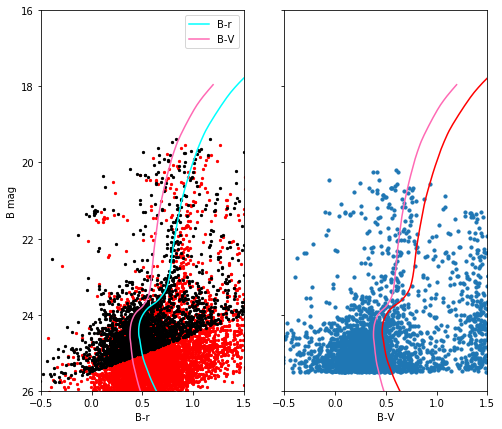

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,7),sharex=True,sharey=True)

ax1.scatter(mBd-mrd,mrd,s=5,color='red')
ax1.scatter(mBu-mRu,mRu,s=5,color='black')

ax1.plot(iso['B']-isoR['sdss_r'],isoR['sdss_r']+20.625,color='cyan',label='B-r')
ax1.plot(iso['B']-iso['V'],iso['V']+20.625,color='hotpink',label='B-V')

ax2.scatter(mBu-mVu,mBu,s=10)
ax2.plot(iso['B']-iso['V'],iso['V']+20.625,color='hotpink')
ax2.plot(iso['B']-isoR['sdss_r'],isoR['sdss_r']+20.625,color='red')

ax1.set_ylim(26,16)
ax1.set_xlim(-0.5,1.5)

ax1.set_xlabel('B-r')
ax2.set_xlabel('B-V')

ax1.set_ylabel('r mag')
ax1.set_ylabel('B mag')

ax1.legend()

plt.show()

In [19]:
outArr1 = np.vstack([rau,decu,mBu,mRu])

In [20]:
np.savetxt('cmdHerc.dat',outArr1.T,header='RA DEC Bc Rc')

In [21]:
isoArr = np.vstack([iso['B'],isoR['sdss_r']])

In [22]:
np.savetxt('isoHerc.dat',isoArr.T,header='B r')

In [23]:
len(cat_c)

24185

In [24]:
ra0 = 247.7582917 
dec0 = 12.7917

x = np.cos(np.deg2rad(dec)) * np.sin(np.deg2rad(ra-ra0))
y = np.sin(np.deg2rad(dec)) * np.cos(np.deg2rad(dec0)) \
    - np.cos(np.deg2rad(dec)) * np.sin(np.deg2rad(dec0)) * np.cos(np.deg2rad(ra-ra0))

# in degrees now 0.2255 arcsec/pixel
# 3600 arcseconds per degree

xpix = np.rad2deg(x) * (3600/0.2255)
ypix = np.rad2deg(y) * (3600/0.2255)

x0 = 0
y0 = 0

In [25]:
xgood = -1*xpix[mB<25.5]
ygood = ypix[mB<25.5]
mBgood = mB[mB<25.5]
mVgood = mV[mB<25.5]

In [26]:
dist = np.sqrt(xgood**2 + ygood**2)

In [27]:
xuse = xgood[dist <= 1570]
yuse = ygood[dist <= 1570]
mBuse = mBgood[dist <= 1570]
mVuse = mVgood[dist <= 1570]

In [28]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [29]:
herc_ext_d = 6.27/60 # degrees
herc_ext_pix_d = herc_ext_d*(3600/0.2255)

In [30]:
rich_d = 1800
x_d = 1.2793787463139303 
y_d = -2.6330748750413733
herc_ext_fit_d = herc_ext_pix_d
herc_ell_fit_d = 0.67
herc_pa_fit_d = -72.59

In [31]:
def plummer(radius,rich,r_h,ell):
    
    term1 = rich / (np.pi * r_h**2 * (1-ell))
    term2 = (1 + (radius**2/r_h**2))**(-2)
    
    
    # stars per squared pixel
    return term1 * term2 * (1/0.2255)**2 * 60**2
    

In [32]:
def densArc(bkg,scale=0.2255):
    
    bkgAS = bkg * (scale)**2
    bkgAM = bkgAS * (1/60)**2
    
    return bkgAM

In [33]:
def extent(arcmin,scale=0.2255):
    
    return (arcmin * 60 / scale)

In [34]:
b1 = densArc(0.0019)
b2 = densArc(0.0129)
b3 = densArc(0.02817)
b4 = densArc(0.0199)
b5 = densArc(0.0085)

In [35]:
r_h_d = herc_ext_fit_d
dist_d = np.array([r_h_d*0.01,r_h_d*0.1,r_h_d*0.2,r_h_d*0.3,r_h_d*0.4,r_h_d*0.5,r_h_d*0.6,r_h_d*0.7,r_h_d*0.8,r_h_d*0.9,r_h_d,
                  1.1*r_h_d,1.2*r_h_d,1.3*r_h_d,1.4*r_h_d,1.5*r_h_d,2*r_h_d,2.5*r_h_d,3*r_h_d])

In [36]:
arr = np.array([0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,
               0.9,1,1.1,1.2,1.5,2,3])

In [37]:
rh1 = extent(7.7)
rh1_arr = rh1 * arr

In [38]:
plummerd = plummer(dist_d,rich_d,r_h_d,herc_ell_fit_d)

In [39]:
plummer1 = plummer(rh1_arr,3678,rh1,0.67) # 1003_1

In [40]:
rh2 = extent(6)
rh2_arr = rh2 * arr
plummer2 = plummer(rh2_arr,1067,rh2,0.4) # 1503_10

In [41]:
rh3 = extent(13.06)
rh3_arr = rh3 * arr
plummer3 = plummer(rh3_arr,5390,rh3,0.67) # 1003_5

In [42]:
rh4 = extent(9.5)
rh4_arr = rh4 * arr
plummer4 = plummer(rh4_arr,1621,rh4,0.67) # 1603_9

In [44]:
rh5 = extent(6.27)
rh5_arr = rh5 * arr
plummer5 = plummer(rh5_arr,1266,rh5,0.49) # 1603_12

In [46]:
rh6 = extent(6.7)
rh6_arr = rh6 * arr
plummer6 = plummer(rh6_arr,1314,rh6,0.52) # 1603_9

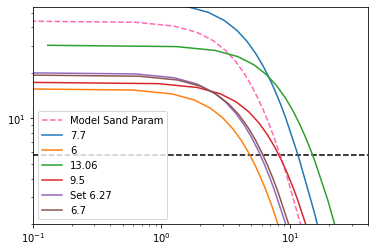

In [47]:
fig, ax = plt.subplots()

# ax.hlines(b1,0.1,100)
# ax.hlines(b2,0.1,100)
# ax.hlines(b3,0.1,100)
ax.hlines(5.73,0.1,100,ls='--')
ax.plot(dist_d*0.2255/60,plummerd,label='Model Sand Param',color='hotpink',linestyle='--')
ax.plot(rh1_arr*0.2255/60,plummer1,label='7.7')
ax.plot(rh2_arr*0.2255/60,plummer2,label='6')
ax.plot(rh3_arr*0.2255/60,plummer3,label='13.06')
ax.plot(rh4_arr*0.2255/60,plummer4,label='9.5')
ax.plot(rh5_arr*0.2255/60,plummer5,label='Set 6.27')
ax.plot(rh6_arr*0.2255/60,plummer6,label='6.7')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1,40)
ax.set_ylim(2,55)

ax.legend()

plt.show()